In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# import mglearn


# Imputing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modelling Preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold


# Supervised
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import RBFSampler

from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier,
                              AdaBoostClassifier,
                              BaggingClassifier)


import xgboost
from xgboost import XGBClassifier

import shap
shap.initjs()

# Metrics 
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_excel('../../../KPMG_Tag_20_edit_doc_title.xlsx', header = 0)

In [3]:
df.head()

,Index_ID,text,document,Comment,Class,df_idx,font-size,font-weight,font-style,left,...,Num_Words,String_Length,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,Left_Px,LS
0,1,2014-10-10 00:00:00,html_files/CMS_2014_0115_0059.pdf,Date,0,12064,11px,0,0,72px,...,3,16,1,0,0,0,0,0,72,NaN
1,2,Centers for Medicare & Medicaid Services,html_files/CMS_2014_0115_0059.pdf,Address,0,12065,11px,0,0,72px,...,6,40,1,0,0,0,0,0,72,27.0
2,3,Department of Health and Human Services,html_files/CMS_2014_0115_0059.pdf,NaN,0,12066,11px,0,0,72px,...,6,39,1,0,0,0,0,0,72,13.0
3,4,Attention: CMS-9968-P,html_files/CMS_2014_0115_0059.pdf,NaN,0,12067,11px,0,0,72px,...,2,21,1,0,0,0,0,0,72,14.0
4,5,P.O. Box 8013,html_files/CMS_2014_0115_0059.pdf,NaN,0,12068,11px,0,0,72px,...,3,13,1,0,0,0,1,0,72,13.0


In [4]:
df.isna().sum() # comment and LS are missing 

Index_ID                    0
text                        0
document                    0
Comment                  3467
Class                       0
df_idx                      0
font-size                   0
font-weight                 0
font-style                  0
left                        0
top                         0
Num_Words                   0
String_Length               0
Leading_Char_Upper          0
Leading_Numeral             0
Ends_In_Period              0
Leading_Number_Period       0
Leading_Char_Period         0
Roman_Period                0
Left_Px                     0
LS                        118
dtype: int64

#### Clean px and convert to right data type for columns: fontsize, left and top

In [5]:
df['font-size'] = df['font-size'].str.replace('px', '')
df['font-size'] = pd.to_numeric(df['font-size'])

df['left'] = df['left'].str.replace('px', '')
df['left'] = pd.to_numeric(df['left'])

df['top'] = df['top'].str.replace('px', '')
df['top'] = pd.to_numeric(df['top'])

#### Separate Target and Features and drop unnecessary columns: Text, Document, Comment and Target

In [6]:
X = df.drop(['text', 'document', 'Comment', 'Index_ID' , 'Class'], axis = 1)
y = df['Class']

#### Check out imbalance
* There is a lot of imbalance here guys, funnily I got the number right haha it is about 95% 

In [7]:
imbalance = (len(y[y == 1]) / len(y)) * 100
print('Class Imblance: {:.2f}%'.format(imbalance))

Class Imblance: 1.40%


In [8]:
X.shape

(4132, 16)

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132 entries, 0 to 4131
Data columns (total 16 columns):
df_idx                   4132 non-null int64
font-size                4132 non-null int64
font-weight              4132 non-null int64
font-style               4132 non-null int64
left                     4132 non-null int64
top                      4132 non-null int64
Num_Words                4132 non-null int64
String_Length            4132 non-null int64
Leading_Char_Upper       4132 non-null int64
Leading_Numeral          4132 non-null int64
Ends_In_Period           4132 non-null int64
Leading_Number_Period    4132 non-null int64
Leading_Char_Period      4132 non-null int64
Roman_Period             4132 non-null int64
Left_Px                  4132 non-null int64
LS                       4014 non-null float64
dtypes: float64(1), int64(15)
memory usage: 516.6 KB


In [10]:
X.isna().sum() # LS are missing: We will impute after Train Test split to prevent leakage

df_idx                     0
font-size                  0
font-weight                0
font-style                 0
left                       0
top                        0
Num_Words                  0
String_Length              0
Leading_Char_Upper         0
Leading_Numeral            0
Ends_In_Period             0
Leading_Number_Period      0
Leading_Char_Period        0
Roman_Period               0
Left_Px                    0
LS                       118
dtype: int64

#### Train Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state = 9834) 

#### Impute Train and Test: We will impute with LS column in both Test and Train with the Median of Train since these are discrete values

In [12]:
ct = ColumnTransformer([("norm1", SimpleImputer(strategy='median'), ['LS'])])

In [13]:
ct.fit(X_train) # Fit on X_train only

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('norm1', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0), ['LS'])])

In [14]:
X_train['LS'] = ct.transform(X_train) 
X_test['LS'] = ct.transform(X_test) 

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Look at cross-validated performance

In [15]:
lr_scores = cross_val_score(LogisticRegression(solver = 'lbfgs'), 
                        X_train, y_train, 
                        cv = 5,
                        scoring= 'roc_auc') # cross validation
lr_mean_score = np.mean(lr_scores)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.

In [16]:
lr_mean_score

0.6963266048372431

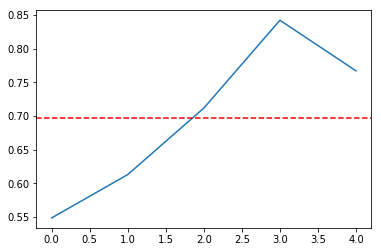

In [17]:
plt.plot(lr_scores)
plt.axhline(lr_mean_score, color='r', linestyle='--') # plot mean line 
plt.show()

#### Fit one model

In [18]:
lr = LogisticRegression(penalty = 'l2', 
                        C = 1, 
                        class_weight = 'balanced', 
                        solver = 'sag', 
                        max_iter = 100, 
                        random_state = 4896) 
lr.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=4896,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [19]:
y_pred = lr.predict(X_test)

#### Model Performance

In [20]:
# Evaluate model performance over these three metrics
print("Score on Train set (only)")
print("Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print("ROC AUC score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Score on Train set (only)
Accuracy score: 0.97
F1 score: 0.00
ROC AUC score: 0.49


In [21]:
cm = confusion_matrix(y_test, y_pred)
print("True Negatives:", cm[0][0])
print("False Negatives:", cm[1][0])
print("True Positives:", cm[1][1])
print("False Positives:", cm[0][1])

True Negatives: 1001
False Negatives: 14
True Positives: 0
False Positives: 18


#### Look at the Important Features

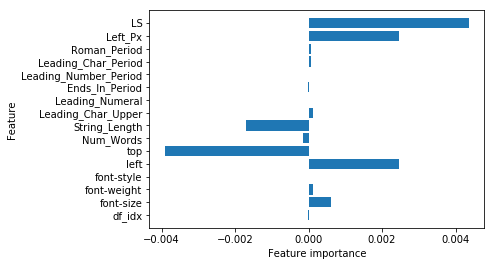

In [22]:
n_features =  X_train.shape[1]
coefs_lr = lr.coef_[0]
plt.barh(range(n_features), coefs_lr, align='center') 
plt.yticks(np.arange(n_features), list(X_train.columns.values)) 
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)
plt.show()

#### Random Forest

In [23]:
rf = RandomForestClassifier() 
rf.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
y_pred = rf.predict(X_test)

#### Model Performance

In [25]:
# Evaluate model performance over these three metrics
print("Score on Train set (only)")
print("Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print("ROC AUC score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Score on Train set (only)
Accuracy score: 0.99
F1 score: 0.55
ROC AUC score: 0.78


In [26]:
cm = confusion_matrix(y_test, y_pred)
print("True Negatives:", cm[0][0])
print("False Negatives:", cm[1][0])
print("True Positives:", cm[1][1])
print("False Positives:", cm[0][1])

True Negatives: 1012
False Negatives: 6
True Positives: 8
False Positives: 7


#### Look at the Important Features

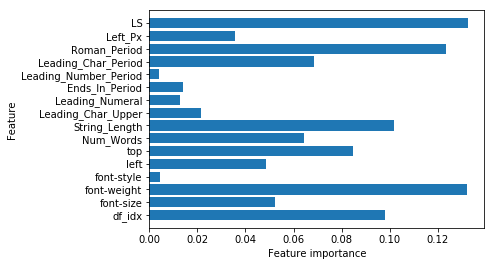

In [27]:
n_features =  X_test.shape[1]
rf_feature_importances = rf.feature_importances_
plt.barh(range(n_features), rf_feature_importances, align='center') 
plt.yticks(np.arange(n_features), list(X_test.columns.values)) 
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)
plt.show()

#### Adaboost

In [28]:
ab = AdaBoostClassifier() 
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [29]:
y_pred = ab.predict(X_test)

#### Model Performance

In [30]:
# Evaluate model performance over these three metrics
print("Score on Train set (only)")
print("Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print("ROC AUC score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Score on Train set (only)
Accuracy score: 0.99
F1 score: 0.48
ROC AUC score: 0.75


In [31]:
cm = confusion_matrix(y_test, y_pred)
print("True Negatives:", cm[0][0])
print("False Negatives:", cm[1][0])
print("True Positives:", cm[1][1])
print("False Positives:", cm[0][1])

True Negatives: 1011
False Negatives: 7
True Positives: 7
False Positives: 8


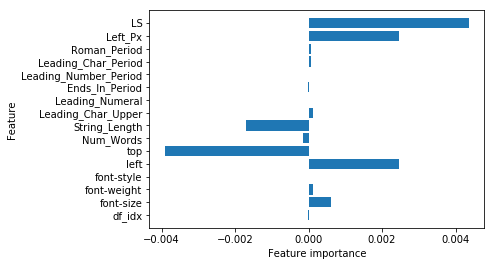

In [32]:
n_features =  X_test.shape[1]
ab_feature_importances = ab.feature_importances_
plt.barh(range(n_features), coefs_lr, align='center') 
plt.yticks(np.arange(n_features), list(X_test.columns.values)) 
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)
plt.show()

#### XGBoost

In [33]:
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [34]:
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}

In [35]:
model_train = xgboost.train(params, xgb_train, 10, evals = [(xgb_test, "test")])

[14:36:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]	test-cox-nloglik:2.63906
[14:36:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[1]	test-cox-nloglik:2.63906
[14:36:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[2]	test-cox-nloglik:2.63906
[14:36:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[3]	test-cox-nloglik:2.63906
[14:36:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[4]	test-cox-nloglik:2.63907
[14:36:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[5]	test-cox-nloglik:2.63907
[14:36:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[6]	test-cox-nloglik:2.63907
[14:36:04] src/tre

In [36]:
predictions = np.round(model_train.predict(xgb_test))

In [37]:
accuracy = accuracy_score(y_test, predictions)

In [38]:
X = X_test
y = y_test
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model_train)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [39]:
shap_values = shap.TreeExplainer(model_train).shap_values(X_train)

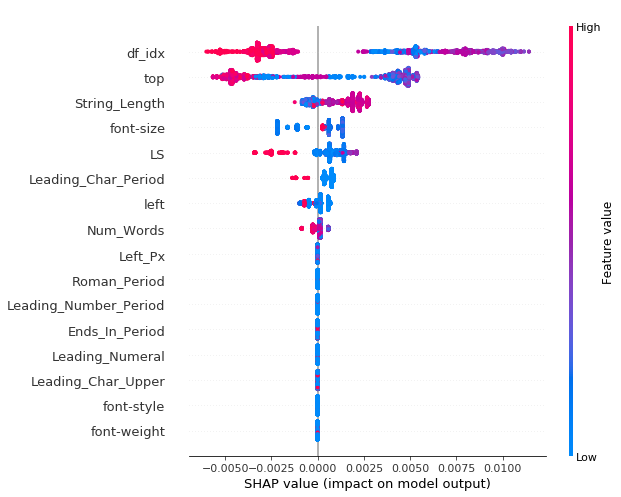

In [40]:
shap.summary_plot(shap_values, X_train)

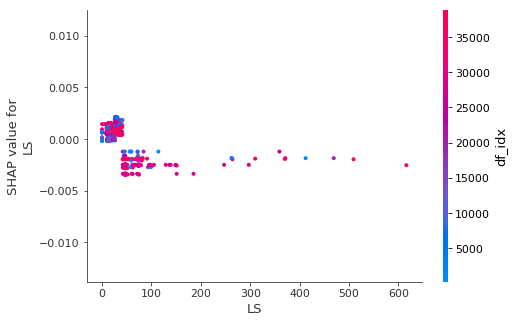

In [41]:
# we pass display_features so we get text display values for age
shap.dependence_plot("LS", shap_values, X_train)